## This script is used to check the mocks we use

### Current version -- AbacusHF-v1: 

box_path = /global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/\<realization\>/Boxes/\<tracer\>/abacus_HF_\<tracer\>_\<redshift\>_\<version\>_\<realization\>_clustering.dat.fit

cutsky_path = /global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/\<realization\>/Cutsky/\<tracer\>/abacus_HF_\<tracer\>_\<redshift\>_\<version\>_\<realization\>_clustering.dat.fit

forclustering_path = /global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0/\<realization\>/Cutsky/\<tracer\>/abacus_HF_\<tracer\>_\<redshift\>_\<version\>_\<realization\>_clustering.dat.fit

In [3]:
import sys
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table,join,Column
from cosmoprimo.fiducial import DESI, AbacusSummit

from scipy.interpolate import interp1d

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_BIN_OVERALL, REDSHIFT_ABACUSHF_v1
from helper import CSPEED, TRACER_CUTSKY_INFO
from helper import GET_REPEATS_DV, GET_CTHR, GET_REPEATS_NUMBER

ABACUSHF_DIR = f'/global/cfs/projectdirs/desi/mocks/cai/abacus_HF/DR2_v1.0'
LOCAL_DIR = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'

def zfmt(x):
    return f"{x:.3f}".replace(".", "p")

BOXSIZE = 2000

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
tracer = 'QSO'
z= REDSHIFT_ABACUSHF_v1[tracer][0]

mock_id = '000'

# data_fn = ABACUSHF_DIR+ '/AbacusSummit_base_c000_ph000/Boxes/LRG/abacus_HF_LRG_0p500_DR2_v1.0_AbacusSummit_base_c000_ph000_clustering.dat.fits'
cubic_name = f'/abacus_HF_{tracer}_{zfmt(z)}_DR2_v1.0_AbacusSummit_base_c000_ph{mock_id}_clustering.dat.fits'
data_fn = LOCAL_DIR+ f'/Boxes/{tracer}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}'+cubic_name
data = Table.read(data_fn)
print(data_fn)
data

/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph000/abacus_HF_QSO_1p400_DR2_v1.0_AbacusSummit_base_c000_ph000_clustering.dat.fits


X,Y,Z,VX,VY,VZ,HALO_MASS,HALO_ID,IS_CENTRAL,X_RSD,Y_RSD,Z_RSD,VZ_OBS,Z_OBS
float64,float64,float64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64
-999.5970458984375,-999.1553955078125,-834.3856201171875,-421.20736123501945,-151.8582328793694,337.8748883209528,1273885238353.6501,140000000,True,995.9021064420577,999.2219102210628,1169.2247712013448,231758.9261385761,1642.0944139013181
-998.8013916015625,-998.6041259765625,-834.808349609375,-441.05190555685476,-375.49933864289034,585.142952010269,1465811656714.879,140003000,True,996.4857101456026,997.3834433894594,1171.4442459727843,620.2227773368038,1171.8190944779335
-998.616455078125,-999.9208984375,-689.7199096679688,-116.13937729649764,-247.47624270181979,239.98268761375948,1699919705485.1687,263003000,True,1000.1425275689289,997.4346727840438,1312.844446079996,269.3537252146965,1313.158292840546
-998.85205078125,-998.8953247070312,-665.1028442382812,12.736542377953088,-92.2626977045932,631.7525702080413,1318175950283.1643,284002000,True,1001.2840466430304,1000.1187942632409,1341.6478024471655,737.7637440991325,1342.780594007337
-998.6487426757812,-999.6947631835938,-660.3684692382812,-14.933937605194448,370.41967322642085,582.92319663839,2653224552729.953,288000000,True,1001.1916794433373,1004.2633882465884,1345.8604069560192,667.7465072998358,1346.7667937725805
-998.841064453125,-998.7299194335938,-561.7134399414062,-0.5494679046537169,-146.1615723634378,-44.751503900684476,1280212482915.0093,372002000,True,1001.1530641600945,999.7082584535337,1437.8083639962074,-398.3680233403156,1434.029764117954
-998.7830200195312,-999.8143310546875,-537.18310546875,-60.21917990250893,307.52864466255915,117.2751166914664,2583624862555.002,393000000,True,1000.5735027294378,1003.4717928546899,1464.0700479256525,144.13824767620704,1464.3570962333201
-998.81494140625,-999.737548828125,-534.1982421875,96.45441743815762,404.99614750746986,190.57314799945215,8860251467423.318,395000000,True,1002.2157306069421,1004.5900725061099,1467.8381436549098,70286.89062411414,216.8584018175843
-999.235595703125,-999.7916870117188,-404.0475769042969,-115.67753162508858,33.638774306634154,43.04733425012666,1577592977298.891,506000000,True,999.5283220357638,1000.5677630182206,1596.412409106013,-937.4142348161434,1585.9356022775967


## Add redshift errros to catalogs

In [6]:
GLOBAL_SEED = 123

def sample_from_cdf(cdf_fn, Ngal, vmode, seed=123):
    """Load the |dv| CDF and sample dv."""
    np.random.seed(seed)
    data = np.load(cdf_fn, allow_pickle=True)
    grid = data["grid"]
    cdf  = data["cdf"]
    cdf_unique, ind = np.unique(cdf, return_index=True)
    grid_unique = grid[ind]
    inv_cdf = interp1d(
        cdf_unique / cdf_unique[-1],
        grid_unique,
        bounds_error=False,
        fill_value=(grid_unique[0], grid_unique[-1]),
        kind='linear'
    )
    if 'log' in vmode:
        if 'abs' in vmode:
            u = np.random.uniform(0, 1, int(Ngal / 2))
            y = inv_cdf(u)
            dv = np.append(10**y, -10**y)
            if Ngal % 2 == 1:
                dv = np.append([0.0], dv)
            np.random.shuffle(dv)
        elif 'signed' in vmode:
            u = np.random.uniform(0, 1, int(Ngal))
            dv = 10**inv_cdf(u)
    elif 'linear' in vmode:
        u = np.random.uniform(0, 1, int(Ngal))
        dv = inv_cdf(u)
    return dv, inv_cdf

def model_dv_from_cdf(tracer, z1, z2, N, cdf_kind = 'obsCDF', vmode = 'log_signed', seed=123):
    """Return dv_model array for a given mode and (tracer, z-bin).
    dv_real:
        Real dv_real distribution
    
    vmode : {"log-signed", "log-abs", "linear"}, optional
        Controls how the Δv distribution is modeled. Supported options

    cdf_kind : {"KCDF", "obsCDF"}, optional
        Which CDF(s) to use:
            - "LCDF" : kernel-smoothed CDF
            - "obsCDF"  : observed CDF (histogram-based)
    -----
    return 
    dv redshift errros distribution
    """
    if vmode == "log_abs":
        fn = f"{REPEAT_DIR}/vmode/{cdf_kind}_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}.npz"
        dv_model, _ = sample_from_cdf(fn, N, vmode, seed)
        return np.asarray(dv_model, float)
    elif vmode == "log_signed":
        (_N, _p, _n) = GET_REPEATS_NUMBER(tracer, z1, z2)
        N_p = int(N*float(_p/_N))
        N_n = N-N_p
        dv_model_list = []
        for sign, Num in [('+', N_p), ('-', N_n)]:
            fn = f"{REPEAT_DIR}/vmode/{cdf_kind}_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}_{sign}.npz"
            sample, _ = sample_from_cdf(fn, Num, vmode, seed)
            sample = np.asarray(sample, float)
            dv_model_list.append(sample if sign=='+' else -sample)
        dv_model = np.concatenate(dv_model_list)
        np.random.shuffle(dv_model)
        return np.asarray(dv_model, float)
    elif vmode == "linear":
        fn = f"{REPEAT_DIR}/vmode/{cdf_kind}_{tracer}_z{z1:.1f}-{z2:.1f}_{vmode}.npz"
        dv_model, _ = sample_from_cdf(fn, N, vmode, seed)
        return np.asarray(dv_model, float)
    else:
        raise ValueError(f"Unknown mode: {vmode}")


In [34]:
dv = model_dv_from_cdf('LRG', 0.4, 1.1, len(data), seed = GLOBAL_SEED)

dv

array([-5.93665693, 25.54365249, 23.70330826, ..., 60.37915493,
       83.03277362, -4.15939623])

In [ ]:
data['VZ_OBS'] = data['VZ'] + dv

cosmo = DESI()
Hz = cosmo.H0 * cosmo.efunc(z)/cosmo.h

data['Z_OBS']=(data['Z_RSD']+dv*(1+z)/Hz) %BOXSIZE

In [ ]:
(data['Z_OBS'])

9.097974959192123e-05

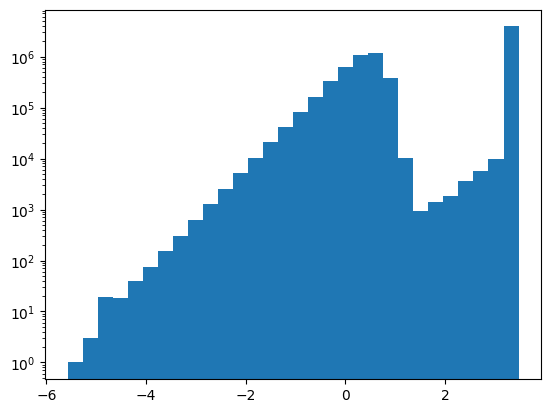

In [ ]:
# plt.hist(np.log10(abs(data['VZ_obs'] - data['VZ'])), bins=20)
plt.hist(np.log10(abs(data['Z_OBS'] - data['Z'])), bins=30)
plt.yscale('log')

## Check the Cutsky mocks

In [18]:
tracer = 'QSO'
z = REDSHIFT_ABACUSHF_v1[tracer][0]
tracer_type = TRACER_CUTSKY_INFO[tracer]['tracer_type']
fit_range   = TRACER_CUTSKY_INFO[tracer]['fit_range']

mock_id = '000'
cutsky_name = f'cutsky_abacusHF_DR2_{tracer_type}_z{zfmt(z)}_zcut_{fit_range}_clustering.dat.fits'
data_fn = LOCAL_DIR+ f'/Cutsky/{tracer_type[:3]}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}/forclustering/'+cutsky_name
data = Table.read(data_fn)
data

RA,DEC,TRUEZ,STATUS,RAW_NZ,RAN_NUM_0_1,NZ,Z,HALO_ID,HALO_MASS,IS_CENTRAL,Z_ERR_3GAUSS,Z_ERR_SIG500,WEIGHT,DESI_TARGET,PRIORITY_INIT,PRIORITY,NUMOBS_MORE,NUMOBS_INIT,BGS_TARGET,TARGETID,MWS_TARGET,SUBPRIORITY,BRICKNAME,OBSCONDITIONS,SCND_TARGET,ZWARN,Z_OBS_GLOBAL,Z_OBS_BIN
float32,float32,float32,int32,float32,float32,float32,float32,int64,float32,bool,float32,float32,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes8,int64,int64,int64,float64,float32
217.55153,1.8414685,1.1437448,43,0.003194513,0.011035746,4.9679613e-05,1.1429893,3930068000000,2077445300000.0,True,0.0008590791,-0.0044639804,1.0,4,3400,3400,4,4,0,400000001,0,0.9696583429084323,000p0000,1,0,0,1.1413772866863314,1.1443044
217.19345,3.67111,1.1374837,43,0.003194513,0.011961465,4.9543673e-05,1.1396712,104110136000000,1385666600000.0,True,0.00504106,0.0019987745,1.0,4,3400,3400,4,4,0,400000002,0,0.1869744381807663,000p0000,1,0,0,1.1405997286957443,1.1396261
217.34724,4.79561,1.1413084,43,0.003194513,0.0016696423,4.962017e-05,1.1431365,304050178004000,1493229800000.0,True,0.0049052946,-0.0038642152,1.0,4,3400,3400,4,4,0,400000003,0,0.7720356196888851,000p0000,1,0,0,1.1429296234872028,1.143235
217.51744,3.2321284,1.1408952,43,0.003194513,0.0034600617,4.9611906e-05,1.1370734,403980120005000,1408866500000.0,True,-0.0007731378,-0.004062222,1.0,4,3400,3400,4,4,0,400000004,0,0.48735631537143775,000p0000,1,0,0,1.135950248126272,1.1380912
217.59396,1.7722245,1.1398253,43,0.003194513,0.0066949436,4.9590508e-05,1.140666,503950066000000,1541738600000.0,True,-0.0023599807,-0.0013229193,1.0,4,3400,3400,4,4,0,400000005,0,0.4587208419481894,000p0000,1,0,0,1.1399178676529942,1.1411294
217.47078,1.8803456,1.1354061,43,0.003194513,0.0062267263,4.9502123e-05,1.1373035,704020069000000,4275108300000.0,True,-0.004615236,0.0017236162,1.0,4,3400,3400,4,4,0,400000006,0,0.9939206602348448,000p0000,1,0,0,1.1368488147492843,1.1382946
217.1395,8.235693,1.14304,43,0.003194513,0.012575151,4.965752e-05,1.1388535,804190306000000,5350739700000.0,True,6.4372754e-05,0.002329285,1.0,4,3400,3400,4,4,0,400000007,0,0.6080038067845952,000p0000,1,0,0,1.1389036560289807,1.1395483
217.52441,3.8942292,1.1358178,43,0.003194513,0.009314177,4.9510356e-05,1.1365966,1104030144000000,1794828400000.0,True,-0.0014228192,0.0033024203,1.0,4,3400,3400,4,4,0,400000008,0,0.3628388754517994,000p0000,1,0,0,1.1354487625510652,1.136171
217.99664,3.266183,1.1429235,43,0.003194513,0.00086973765,4.965387e-05,1.1409655,1303820122000000,936432200000.0,True,0.00264895,0.0049319174,1.0,4,3400,3400,4,4,0,400000009,0,0.10301515532937011,000p0000,1,0,0,1.140729068767925,1.1405563


In [39]:
data_fn

'/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/ELG/z0.950/AbacusSummit_base_c000_ph000/forclustering/cutsky_abacusHF_DR2_ELG_z0p950_zcut_0p8to1p6_clustering.dat.fits'

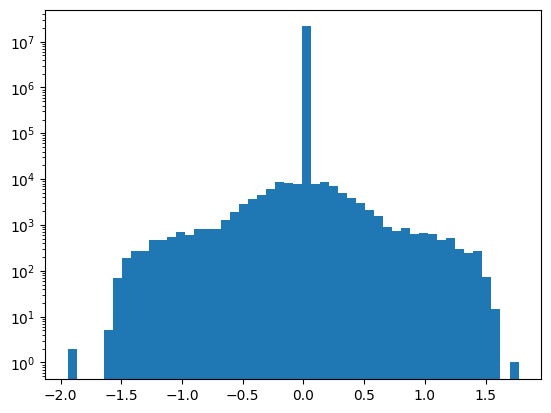

In [6]:
plt.hist(data['Z_OBS_GLOBAL'] - data['Z_OBS_BIN'], bins=50,)
plt.yscale('log')

-4.903413267274242

## Check the randoms

In [4]:
# load the randoms, random length 32943255

ran_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random'

ran_mock_fns = [ran_dir+f'/rands_intiles_DARK_{i}_NO_imagingmask_withz.ran.fits'.format(i) for i in range(8, 8+1)]

print(ran_mock_fns)

ran = Table.read(ran_mock_fns[0])

ran

['/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random/rands_intiles_DARK_8_NO_imagingmask_withz.ran.fits']


RA,DEC,BRICKNAME,BRICKID,NOBS_G,NOBS_R,NOBS_Z,MASKBITS,Z_LRG,WEIGHT,Z_QSO,Z_ELG_LOP,ELG_LOP_MASK
float64,float64,bytes8,int32,int16,int16,int16,int16,float32,float64,float32,float32,bool
263.26957003127893,50.872682195728345,2633p507,587330,3,3,3,2048,0.5953857,1.0,1.5727819,1.1928512,True
257.4066951972251,43.350162955066544,2575p432,557802,3,3,4,0,0.89293617,1.0,1.7004937,1.0900215,True
256.6798214561534,49.80916807106869,2565p497,583619,3,3,5,0,0.48213458,1.0,1.8297571,1.5042626,True
124.93772536522738,51.04988329310739,1248p510,587891,5,4,4,0,0.9130829,1.0,2.3258562,0.90918016,True
171.44139936546492,34.5718040718846,1713p345,518242,3,3,3,0,0.75911355,1.0,1.6073139,1.4200398,True
272.6958568331494,35.546143848351754,2726p355,523302,2,2,3,0,0.58966184,1.0,2.3628173,1.0121537,True
111.40301311591142,36.560228671112824,1112p365,527450,3,5,4,0,0.9274481,1.0,0.91393113,1.0414948,True
135.51270356764292,46.67220276022892,1354p467,571754,4,3,2,0,0.6895867,1.0,1.6632545,0.8989633,True
222.70830329842923,43.95252627675806,2227p440,560837,3,3,1,0,0.7841586,1.0,1.8262196,1.4543241,True


(array([397942., 561836., 646785., 641815., 545358., 418915., 288626.,
        185533., 110636.,  56895.]),
 array([0.8      , 1.0699999, 1.3399999, 1.6099998, 1.8799998, 2.1499996,
        2.4199996, 2.6899996, 2.9599993, 3.2299993, 3.4999993],
       dtype=float32),
 <BarContainer object of 10 artists>)

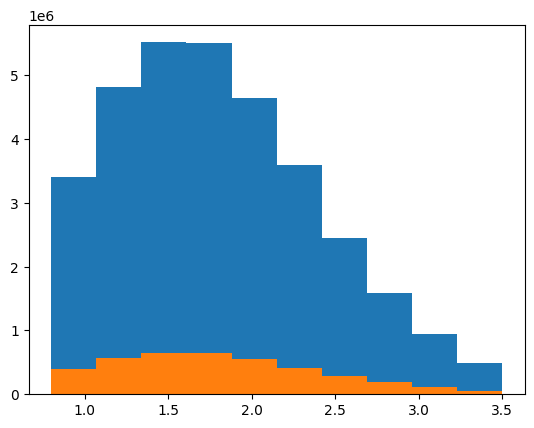

In [19]:
plt.hist(ran['Z_QSO'])
plt.hist(data['Z'])

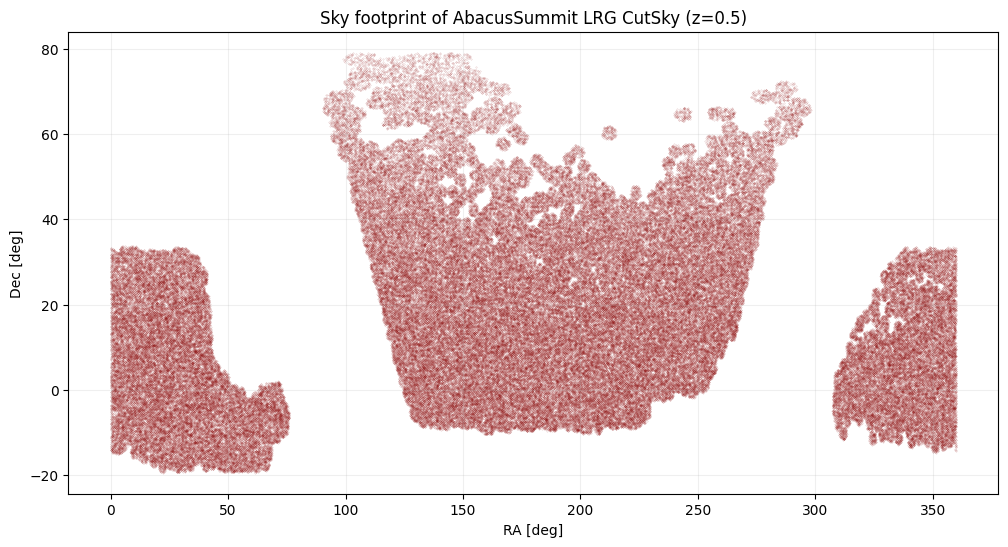

In [5]:
# Extract coordinates
ra = np.asarray(ran['RA'])
dec = np.asarray(ran['DEC'])

# If the catalog is huge, downsample for speed
idx = np.random.choice(len(ra), size=200000, replace=False)  # sample 2e5 points
ra, dec = ra[idx], dec[idx]

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(ra, dec, s=0.05, color='darkred', alpha=0.3)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('Sky footprint of AbacusSummit LRG CutSky (z=0.5)')
plt.grid(alpha=0.2)
plt.show()

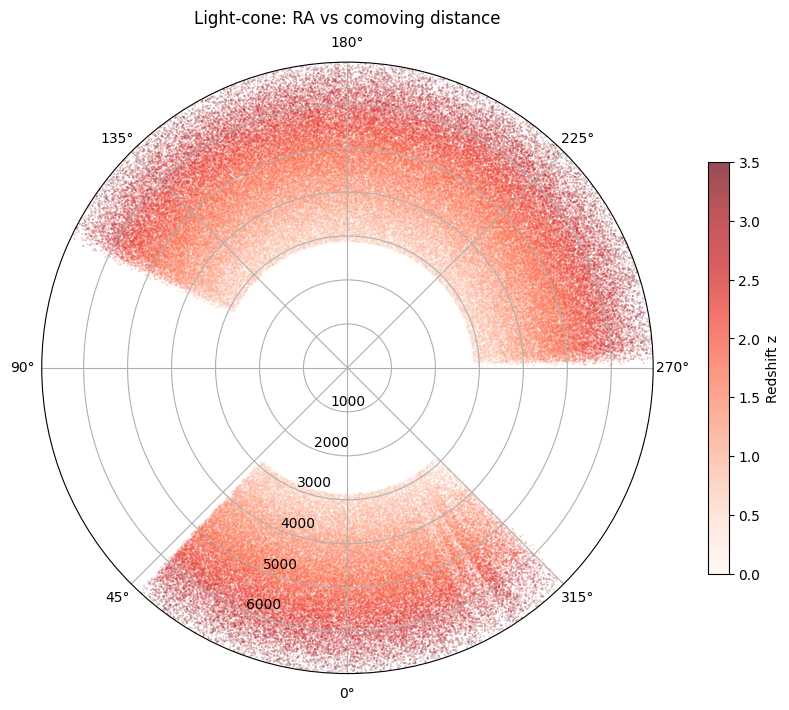

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from astropy.cosmology import Planck18 as cosmo

dec_band_halfwidth = 5.0
max_points = 200000
zmax = 3.5

ra  = np.asarray(ran['RA'], dtype=float)
dec = np.asarray(ran['DEC'], dtype=float)
z   = np.asarray(ran['Z_QSO'],  dtype=float)

dec0 = np.nanmedian(dec)
sel = np.isfinite(z) & (dec > dec0 - dec_band_halfwidth) & (dec < dec0 + dec_band_halfwidth) & (z < zmax)
idx = np.where(sel)[0]
if idx.size > max_points:
    idx = np.random.choice(idx, size=max_points, replace=False)

theta = np.radians(ra[idx])
r = cosmo.comoving_distance(z[idx]).value  # Mpc
rmax = cosmo.comoving_distance(zmax).value

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

norm = Normalize(vmin=0.0, vmax=zmax)     # fixes colorbar range
sc = ax.scatter(theta, r, s=0.02, c=z[idx], cmap='Reds', norm=norm, alpha=0.7)

ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.set_rmin(0); ax.set_rmax(rmax)
ax.set_title('Light-cone: RA vs comoving distance', va='bottom')

cb = plt.colorbar(sc, pad=0.08, fraction=0.03, shrink=0.8)
cb.set_label('Redshift z')

plt.tight_layout()
plt.show()


In [6]:
# Extract coordinates
ra = np.asarray(data['RA'])
dec = np.asarray(data['DEC'])

# If the catalog is huge, downsample for speed
idx = np.random.choice(len(ra), size=200000, replace=False)  # sample 2e5 points
ra, dec = ra[idx], dec[idx]

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(ra, dec, s=0.05, color='darkred', alpha=0.3)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.title('Sky footprint of AbacusSummit LRG CutSky (z=0.5)')
plt.grid(alpha=0.2)
plt.show()

NameError: name 'data' is not defined

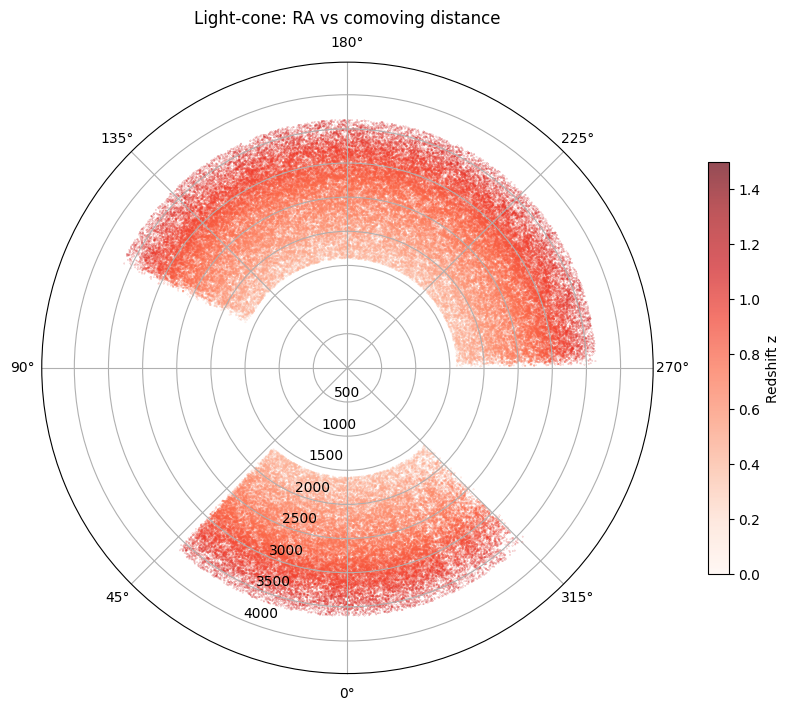

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from astropy.cosmology import Planck18 as cosmo

dec_band_halfwidth = 5.0
max_points = 200000
zmax = 1.5

ra  = np.asarray(data['RA'], dtype=float)
dec = np.asarray(data['DEC'], dtype=float)
z   = np.asarray(data['Z'],  dtype=float)

dec0 = np.nanmedian(dec)
sel = np.isfinite(z) & (dec > dec0 - dec_band_halfwidth) & (dec < dec0 + dec_band_halfwidth) & (z < zmax)
idx = np.where(sel)[0]
if idx.size > max_points:
    idx = np.random.choice(idx, size=max_points, replace=False)

theta = np.radians(ra[idx])
r = cosmo.comoving_distance(z[idx]).value  # Mpc
rmax = cosmo.comoving_distance(zmax).value

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

norm = Normalize(vmin=0.0, vmax=zmax)     # fixes colorbar range
sc = ax.scatter(theta, r, s=0.02, c=z[idx], cmap='Reds', norm=norm, alpha=0.7)

ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.set_rmin(0); ax.set_rmax(rmax)
ax.set_title('Light-cone: RA vs comoving distance', va='bottom')

cb = plt.colorbar(sc, pad=0.08, fraction=0.03, shrink=0.8)
cb.set_label('Redshift z')

plt.tight_layout()
plt.show()

## APPENDIX

In [11]:
# random length 

for tracer in ['LRG','ELG', 'QSO']:
    for z in REDSHIFT_ABACUSHF_v1[tracer]:
        if tracer == 'LRG':
            tracer_type = 'LRG'
            fit_range = '0p4to1p1'
        elif tracer == 'ELG':
            tracer_type = 'ELG_LOP'
            fit_range = '0p8to1p6'
        elif tracer == 'QSO':
            tracer_type = 'QSO'
            fit_range = '0p8to3p5'
        cutsky_name = f'cutsky_abacusHF_DR2_{tracer_type}_z{zfmt(z)}_zcut_{fit_range}_clustering.dat.fits'
        data_fn = LOCAL_DIR+ f'/Cutsky/{tracer[:3]}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}/forclustering/'+cutsky_name
        data = Table.read(data_fn)
        print(tracer, z, '\t', 10/(32943255/len(data)))

LRG 0.5 	 2.189337088882079
LRG 0.725 	 2.1897857391444773
LRG 0.95 	 2.1889807185112704
ELG 0.95 	 6.5250835110252465
ELG 1.175 	 6.524094841265685
ELG 1.475 	 6.524465782145692
QSO 1.4 	 1.1704738951873455


179.09605747548974


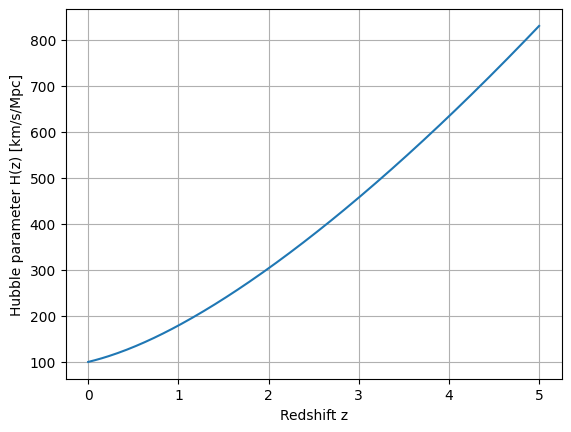

In [60]:
from cosmoprimo.fiducial import DESI, AbacusSummit
import astropy.units as u

# Define redshift range
z = np.linspace(0, 5, 200)

# Load DESI fiducial cosmology
cosmo = DESI()

# Compute H(z)
H_z = cosmo.H0 * cosmo.efunc(z)/cosmo.h   # units: km/s/(Mpc/h)
print(cosmo.H0 * cosmo.efunc(1.0)/ cosmo.h) 
plt.plot(z, H_z)
plt.xlabel("Redshift z")
plt.ylabel("Hubble parameter H(z) [km/s/Mpc]")
plt.grid(True)
plt.show()

In [ ]:
(zmin, zmax) = REDSHIFT_BIN_OVERALL[tracer]
dv = model_dv_from_cdf(tracer, zmin, zmax, len(data))
data['Z_OBS_GLOBAL'] = data['Z']+dv/CSPEED*(1+data['Z'])

data['Z_OBS_BIN'] = data['Z'].copy()
step = 0.1
zrange = np.round(np.arange(zmin, zmax+ step/2, step), 1)
zbins = list(zip(zrange[:-1], zrange[1:]))
for indz, (z1, z2) in enumerate(zbins):
    sel = (data['Z'] >= z1) & (data['Z'] < z2)
    z_sel = data['Z'][sel]
    dv_bin = model_dv_from_cdf(tracer, zmin, zmax, len(z_sel))
    data['Z_OBS_BIN'][sel] = z_sel + dv_bin / CSPEED * (1.0 + z_sel)
    # print(z1, z2)